# [MN 0036535878] Time-series (TS)
### Edi Prodan

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import tabulate as tb
warnings.filterwarnings("ignore")

In [2]:
train_df = pd.read_csv('../data/cleaned_train.csv')
test_df = pd.read_csv('../data/test.csv')

In [3]:
train_df.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Target,Id
0,2010-01-04,MMM,53.295380,83.019997,83.449997,82.669998,83.089996,3043700.0,0,0
1,2010-01-05,MMM,52.961575,82.500000,83.230003,81.699997,82.800003,2847000.0,0,1
2,2010-01-06,MMM,53.712681,83.669998,84.599998,83.510002,83.879997,5268500.0,0,2
3,2010-01-07,MMM,53.751179,83.730003,83.760002,82.120003,83.320000,4470100.0,0,3
4,2010-01-08,MMM,54.129955,84.320000,84.320000,83.300003,83.690002,3405800.0,0,4


### 1. Data preparation

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings("ignore")

In [5]:
aapl_df = train_df[train_df['Symbol'] == 'AAPL']
aapl_df['Date'] = pd.to_datetime(aapl_df['Date'])
aapl_df.set_index('Date', inplace=True)

aapl_df.head()

,Symbol,Adj Close,Close,High,Low,Open,Volume,Target,Id
Date,,,,,,,,,
2010-01-04,AAPL,6.470740,7.643214,7.660714,7.585000,7.622500,493729600.0,1,42619
2010-01-05,AAPL,6.481928,7.656429,7.699643,7.616071,7.664286,601904800.0,1,42620
2010-01-06,AAPL,6.378826,7.534643,7.686786,7.526786,7.656429,552160000.0,1,42621
2010-01-07,AAPL,6.367033,7.520714,7.571429,7.466071,7.562500,477131200.0,1,42622
2010-01-08,AAPL,6.409361,7.570714,7.571429,7.466429,7.510714,447610800.0,1,42623


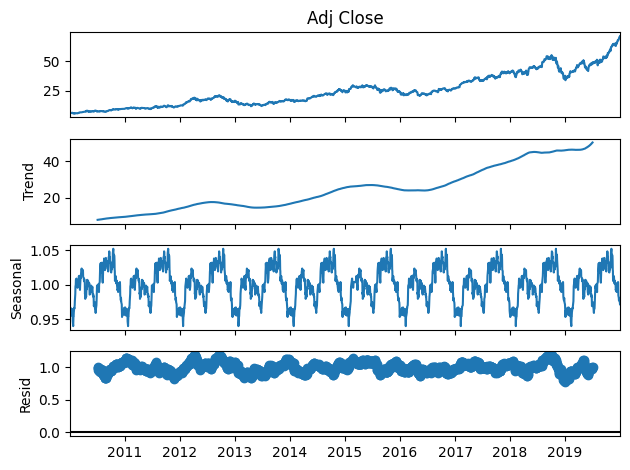

In [6]:
result = seasonal_decompose(aapl_df['Adj Close'], model='multiplicative', period=252)
result.plot();

In [7]:
def plot_stock(df, stock):
    stock_df = df[df['Symbol'] == stock]
    stock_df = stock_df.set_index('Date')
    stock_df['Close'].plot(figsize=(12, 6))
    plt.title(f'Close price of {stock} stock')
    plt.show()

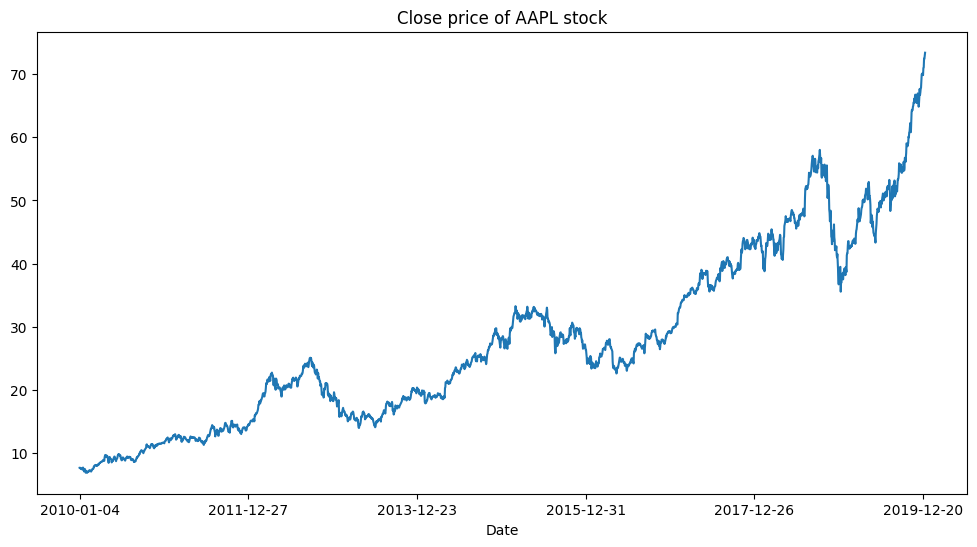

In [8]:
plot_stock(train_df, 'AAPL')

### 2. Exponential smoothing

In [2]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings("ignore")

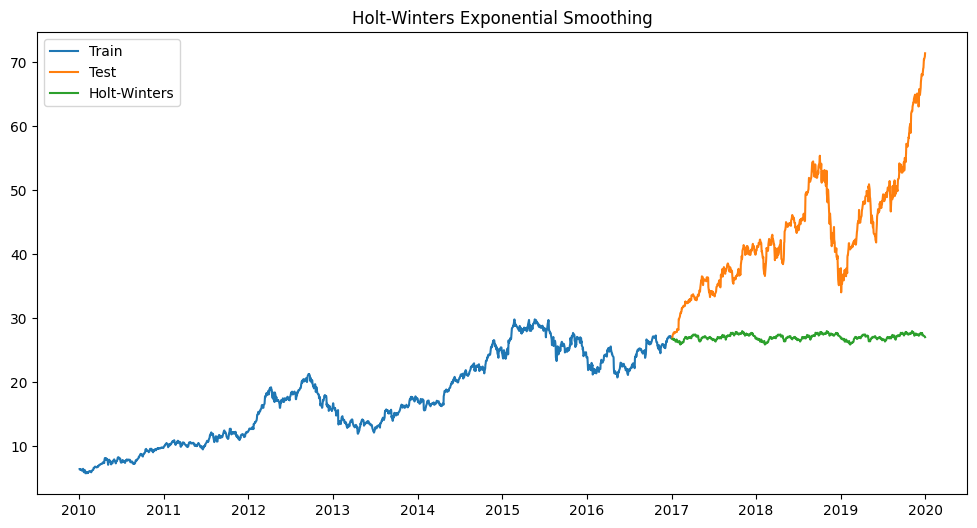

In [10]:
train_set, test_set = train_test_split(aapl_df['Adj Close'], test_size=0.3, shuffle=False)

model = ExponentialSmoothing(train_set, seasonal='add', seasonal_periods=252).fit()

pred = model.forecast(len(test_set))

plt.figure(figsize=(12, 6))

plt.plot(train_set.index, train_set, label='Train')
plt.plot(test_set.index, test_set, label='Test')
plt.plot(test_set.index, pred, label='Holt-Winters')

plt.legend()
plt.title('Holt-Winters Exponential Smoothing')
plt.show()

The green line (forecast) is almost flat compared to the actual test data. This indicates that the model fails to capture the upward trend and underestimates the actual values in the test set.

#### 2.1 parameter optimization

In [11]:
def evaluate_model_exp(train_set, test_set, trend, seasonal, seasonal_periods):
    model = ExponentialSmoothing(train_set, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit()
    pred = model.forecast(len(test_set))
    mse = mean_squared_error(test_set, pred)
    return mse

def grid_search_exp(train_set, test_set, seasonal_periods_list=[252, 126, 63]):
    table_headers = ['Trend', 'Seasonal', 'Seasonal Periods', 'MSE']
    exp_smooth_table = []

    trend_list = ['add', 'mul']
    seasonal_list = ['add', 'mul']
    # seasonal_periods_list = [252, 126, 63]
    
    best_score = float('inf')
    best_params = None
    
    for trend in trend_list:
        for seasonal in seasonal_list:
            for seasonal_periods in seasonal_periods_list:
                try:
                    mse = evaluate_model_exp(train_set, test_set, trend, seasonal, seasonal_periods)
                    exp_smooth_table.append([trend, seasonal, seasonal_periods, mse])
                    if mse < best_score:
                        best_score = mse
                        best_params = (trend, seasonal, seasonal_periods)
                except Exception as e:
                    continue
    
    print(tb.tabulate(exp_smooth_table, headers=table_headers, tablefmt='pretty'))
    return best_params, best_score


+-------+----------+------------------+--------------------+
| Trend | Seasonal | Seasonal Periods |        MSE         |
+-------+----------+------------------+--------------------+
|  add  |   add    |       252        | 191.8028175037883  |
|  add  |   add    |       126        | 185.82862086989212 |
|  add  |   add    |        63        | 195.32401022738136 |
|  add  |   mul    |       252        | 169.6096093286901  |
|  add  |   mul    |       126        | 179.31676515317207 |
|  add  |   mul    |        63        | 197.32794083380296 |
|  mul  |   add    |       252        | 162.18511881059928 |
|  mul  |   add    |       126        | 144.13086980360154 |
|  mul  |   add    |        63        | 177.0635853538735  |
|  mul  |   mul    |       252        | 85.47412368091976  |
|  mul  |   mul    |       126        | 155.9659001539593  |
|  mul  |   mul    |        63        | 179.29384345305843 |
+-------+----------+------------------+--------------------+
Best Parameters: ('mul',

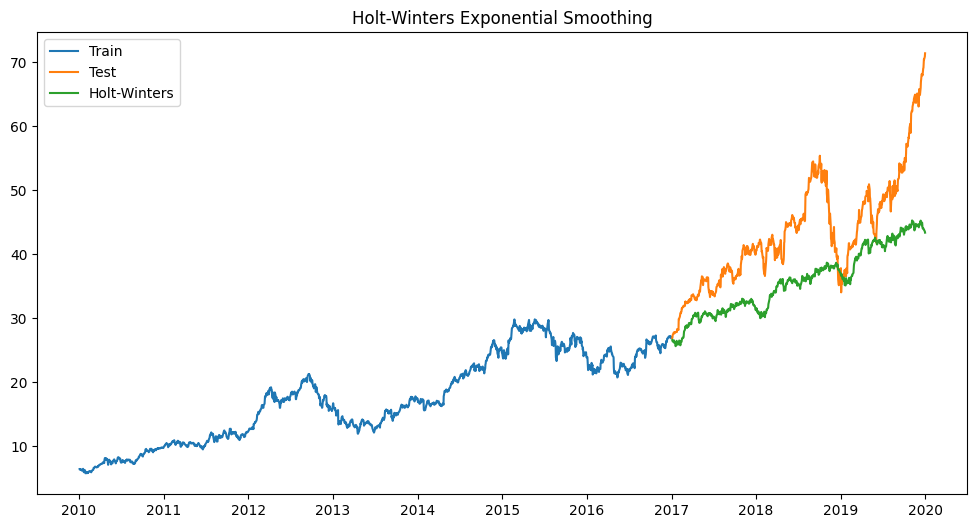

In [12]:
best_params, best_score = grid_search_exp(train_set, test_set)
print(f"Best Parameters: {best_params}")
print(f"Best MAE Score: {best_score}")

best_trend, best_seasonal, best_seasonal_periods = best_params
best_model = ExponentialSmoothing(train_set, trend=best_trend, seasonal=best_seasonal, seasonal_periods=best_seasonal_periods).fit()
pred = best_model.forecast(len(test_set))

plt.figure(figsize=(12, 6))
plt.plot(train_set.index, train_set, label='Train')
plt.plot(test_set.index, test_set, label='Test')
plt.plot(test_set.index, pred, label='Holt-Winters')

plt.legend()
plt.title('Holt-Winters Exponential Smoothing')
plt.show()


After performing the grid search, the model found parameters with least mean squared error and they managed to forecast the trend much better.

### 3. ARIMA

In [13]:
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")

Mean Squared Error: 758.3247946762785
Mean Absolute Error: 26.130324488435434


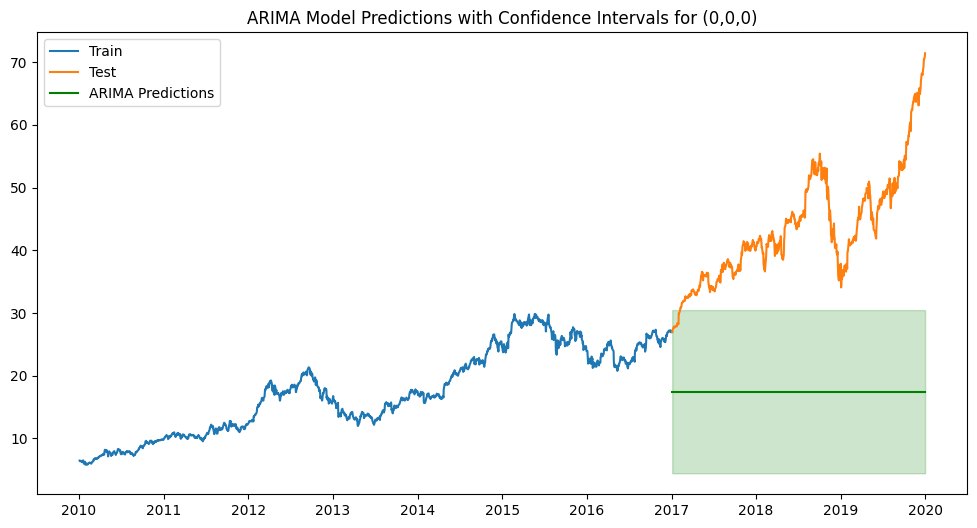

In [14]:
model = ARIMA(train_set, order=(0,0,0)).fit()

forecast = model.get_forecast(len(test_set))

pred = forecast.predicted_mean
conf_int = forecast.conf_int()

pred.index = test_set.index
conf_int.index = test_set.index

mse = mean_squared_error(test_set, pred)
print(f'Mean Squared Error: {mse}')

mae = mean_absolute_error(test_set, pred)
print(f'Mean Absolute Error: {mae}')

plt.figure(figsize=(12, 6))
plt.plot(train_set.index, train_set, label='Train')
plt.plot(test_set.index, test_set, label='Test')
plt.plot(pred.index, pred, label='ARIMA Predictions', color='green')

plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)

plt.legend()
plt.title('ARIMA Model Predictions with Confidence Intervals for (0,0,0)')
plt.show()

A wide confidence interval indicates high uncertainty in the model's predictions. Prediction is not very useful for making precise decisions.

#### 3.1 parameter $p$

In [15]:
p_list = [1,2,3,4,5,10,15,20]
table_headers_p = ['p', 'MSE', 'MAE']
arima_table_p = []

for p in p_list:
    
    model = ARIMA(train_set, order=(p,0,0)).fit()

    forecast = model.get_forecast(len(test_set))

    pred = forecast.predicted_mean
    conf_int = forecast.conf_int()

    pred.index = test_set.index
    conf_int.index = test_set.index

    mse = mean_squared_error(test_set, pred)
    mae = mean_absolute_error(test_set, pred)

    arima_table_p.append([p, mse, mae])

print(tb.tabulate(arima_table_p, headers=table_headers_p, tablefmt='pretty'))

+----+--------------------+--------------------+
| p  |        MSE         |        MAE         |
+----+--------------------+--------------------+
| 1  | 494.71011338806164 | 19.83069494337184  |
| 2  | 498.0469812505242  | 19.90187719644124  |
| 3  | 495.84924376739906 | 19.854494593680908 |
| 4  | 490.86431996619586 | 19.747175076911567 |
| 5  | 491.61531090383795 | 19.763483113968423 |
| 10 | 447.33204768431574 | 18.796456720549223 |
| 15 | 507.3468425043461  | 20.09492139612015  |
| 20 | 450.9732694326214  | 18.867402077762673 |
+----+--------------------+--------------------+


Mean Squared Error: 447.33204768431574
Mean Absolute Error: 18.796456720549223


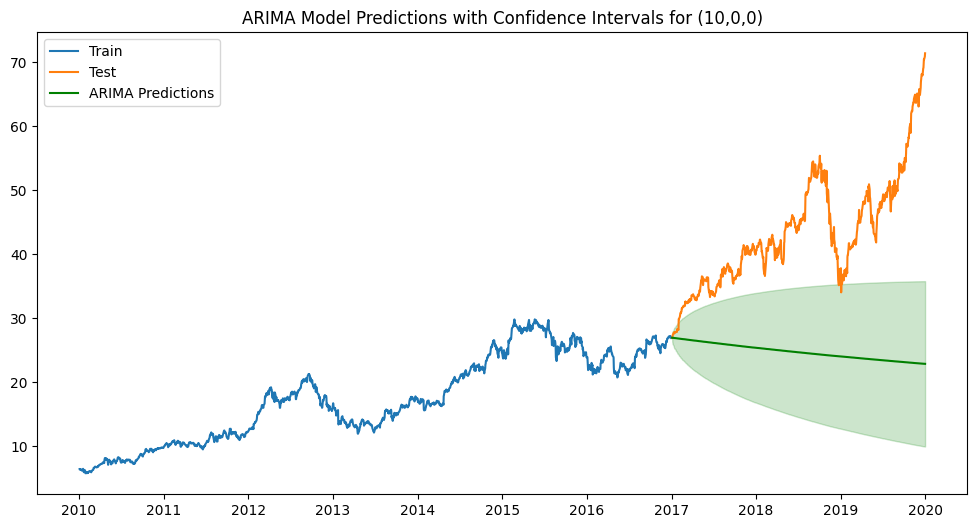

In [16]:
model = ARIMA(train_set, order=(10,0,0)).fit()

forecast = model.get_forecast(len(test_set))

pred = forecast.predicted_mean
conf_int = forecast.conf_int()

pred.index = test_set.index
conf_int.index = test_set.index

mse = mean_squared_error(test_set, pred)
print(f'Mean Squared Error: {mse}')

mae = mean_absolute_error(test_set, pred)
print(f'Mean Absolute Error: {mae}')

plt.figure(figsize=(12, 6))
plt.plot(train_set.index, train_set, label='Train')
plt.plot(test_set.index, test_set, label='Test')
plt.plot(pred.index, pred, label='ARIMA Predictions', color='green')

plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)

plt.legend()
plt.title('ARIMA Model Predictions with Confidence Intervals for (10,0,0)')
plt.show()

The $p$ parameter represents the number of lagged observations (i.e., previous time steps) that are used to predict the current value. In this case, the "optimal"* number of days to look back for the most accurate prediction is 10 days.

*optimization will be performed later in the task.

#### 3.2 parameter $d$

In [17]:
d_list = [1,2,3,4]

table_headers_d = ['d', 'MSE', 'MAE']
arima_table_d = []

for d in d_list:

    model = ARIMA(train_set, order=(0,d,0)).fit()

    forecast = model.get_forecast(len(test_set))

    pred = forecast.predicted_mean
    conf_int = forecast.conf_int()

    pred.index = test_set.index
    conf_int.index = test_set.index

    mse = mean_squared_error(test_set, pred)
    mae = mean_absolute_error(test_set, pred)
    
    arima_table_d.append([d, mse, mae])

print(tb.tabulate(arima_table_d, headers=table_headers_d, tablefmt='pretty'))

+---+--------------------+--------------------+
| d |        MSE         |        MAE         |
+---+--------------------+--------------------+
| 1 | 350.91619191177716 | 16.59481601031178  |
| 2 | 261.1999296009016  | 12.697774724178505 |
| 3 | 1344495492.4343228 | 27349.40818771335  |
| 4 | 178964914812446.28 |  8860782.68779105  |
+---+--------------------+--------------------+


Mean Squared Error: 261.1999296009016
Mean Absolute Error: 12.697774724178505


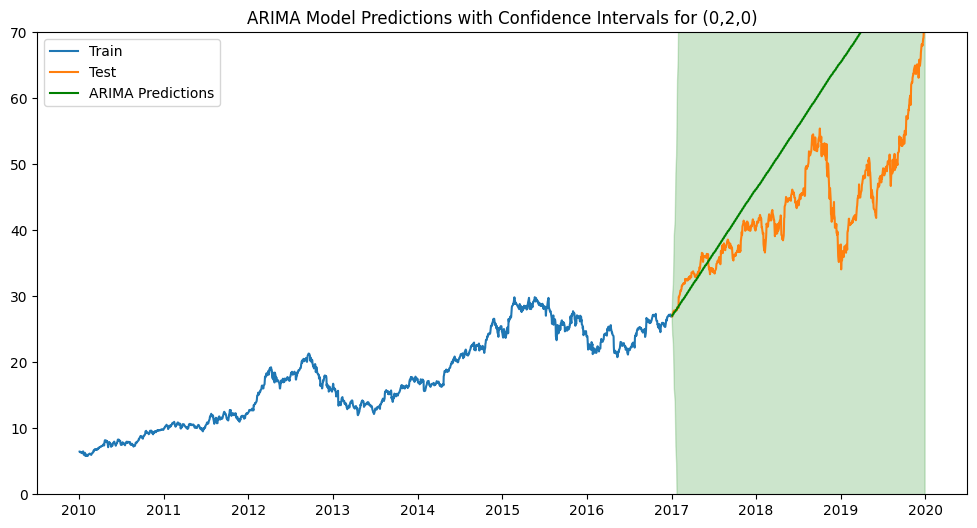

In [18]:
model = ARIMA(train_set, order=(0,2,0)).fit()

forecast = model.get_forecast(len(test_set))

pred = forecast.predicted_mean
conf_int = forecast.conf_int()

pred.index = test_set.index
conf_int.index = test_set.index

mse = mean_squared_error(test_set, pred)
print(f'Mean Squared Error: {mse}')

mae = mean_absolute_error(test_set, pred)
print(f'Mean Absolute Error: {mae}')

plt.figure(figsize=(12, 6))
plt.plot(train_set.index, train_set, label='Train')
plt.plot(test_set.index, test_set, label='Test')
plt.plot(pred.index, pred, label='ARIMA Predictions', color='green')

plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)
plt.ylim(0,70)
plt.legend()
plt.title('ARIMA Model Predictions with Confidence Intervals for (0,2,0)')
plt.show()

The $d$ parameter represents the number of times the data needs to be differenced to make it stationary. In case of $d=2$, the data was differenced twice to achieve stationarity.

#### 3.3 parameter $q$

In [19]:
q_list = [1,5,10,15,20,25]
table_headers_q = ['q', 'MSE', 'MAE']
arima_table_q = []

for q in q_list:
    
    model = ARIMA(train_set, order=(0,0,q)).fit()

    forecast = model.get_forecast(len(test_set))

    pred = forecast.predicted_mean
    conf_int = forecast.conf_int()

    pred.index = test_set.index
    conf_int.index = test_set.index

    mse = mean_squared_error(test_set, pred)
    mae = mean_absolute_error(test_set, pred)
    arima_table_q.append([q, mse, mae])

print(tb.tabulate(arima_table_q, headers=table_headers_q, tablefmt='pretty'))

+----+-------------------+--------------------+
| q  |        MSE        |        MAE         |
+----+-------------------+--------------------+
| 1  | 758.247699730758  | 26.124082750140794 |
| 5  | 758.0493904738166 | 26.102659241817168 |
| 10 | 757.5802627659723 | 26.073007370548353 |
| 15 | 757.2501809558345 | 26.05072585393849  |
| 20 | 756.7921104953753 | 26.015793417019452 |
| 25 | 756.5094066086878 | 26.00108540033421  |
+----+-------------------+--------------------+


Mean Squared Error: 756.5094066086878
Mean Absolute Error: 26.00108540033421


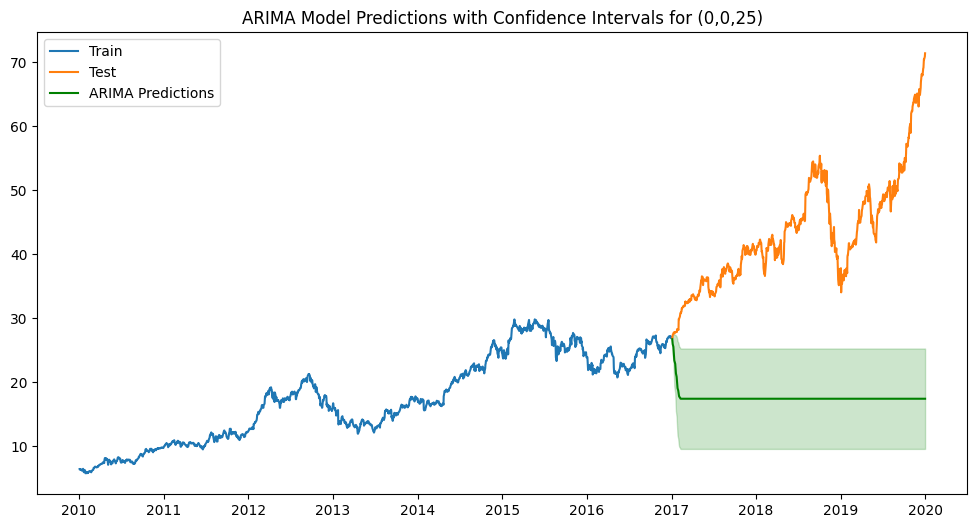

In [20]:
model = ARIMA(train_set, order=(0,0,25)).fit()

forecast = model.get_forecast(len(test_set))

pred = forecast.predicted_mean
conf_int = forecast.conf_int()

pred.index = test_set.index
conf_int.index = test_set.index

mse = mean_squared_error(test_set, pred)
print(f'Mean Squared Error: {mse}')

mae = mean_absolute_error(test_set, pred)
print(f'Mean Absolute Error: {mae}')

plt.figure(figsize=(12, 6))
plt.plot(train_set.index, train_set, label='Train')
plt.plot(test_set.index, test_set, label='Test')
plt.plot(pred.index, pred, label='ARIMA Predictions', color='green')

plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)
plt.legend()
plt.title('ARIMA Model Predictions with Confidence Intervals for (0,0,25)')
plt.show()


The parameter $q$ captures the dependency of the current value on past forecast errors (residuals). For example, if $q=25$, the future value is influenced by the residual errors from the past 25 periods. This helps to capture irregularities on past forecast errors.

#### 3.4 parameter optimization

In [21]:
def evaluate_model_arima(train_set, test_set, params):
    
    model = ARIMA(train_set, order=params).fit()
    forecast = model.get_forecast(len(test_set))
    pred = forecast.predicted_mean
    pred.index = test_set.index
    return mean_squared_error(test_set, pred)
    

def grid_search_arima(train_set, test_set, p_list=range(7,11), d_list=range(0,5), q_list=range(7,11)):
    arima_headers = ['p', 'd', 'q', 'MSE']
    arima_table = []
    # p_list = range(7, 11)
    # d_list = range(0, 5)
    # q_list = range(7, 11)
    
    best_score = float('inf')
    best_params = None
    
    for p in p_list:
        for d in d_list:
            for q in q_list:
                try:
                    mse = evaluate_model_arima(train_set, test_set, (p, d, q))
                    arima_table.append([p, d, q, mse])
                    if mse < best_score:
                        best_score = mse
                        best_params = (p, d, q)
                except Exception as e:
                    continue

    print(tb.tabulate(arima_table, headers=arima_headers, tablefmt='pretty'))
    return best_params, best_score


In [22]:
best_params, best_score = grid_search_arima(train_set, test_set)
print(f"Best Parameters: {best_params}")
print(f"Best MSE Score: {best_score}")

+----+---+----+--------------------+
| p  | d | q  |        MSE         |
+----+---+----+--------------------+
| 7  | 0 | 7  | 361.2117778810862  |
| 7  | 0 | 8  | 359.8037221537215  |
| 7  | 0 | 9  | 424.1764739826942  |
| 7  | 0 | 10 | 380.80889701254273 |
| 7  | 1 | 7  | 348.1109961592883  |
| 7  | 1 | 8  | 350.9716370683941  |
| 7  | 1 | 9  | 344.0386541446688  |
| 7  | 1 | 10 | 341.4227753410947  |
| 7  | 2 | 7  | 195.2952458557654  |
| 7  | 2 | 8  | 192.5382922948894  |
| 7  | 2 | 9  | 192.97465590165726 |
| 7  | 2 | 10 | 192.2952261084118  |
| 7  | 3 | 7  | 167.0883989588553  |
| 7  | 3 | 8  | 689.2649964301128  |
| 7  | 3 | 9  | 232.50880646301556 |
| 7  | 3 | 10 | 604.5188367340428  |
| 7  | 4 | 7  | 1833186.8109682691 |
| 7  | 4 | 8  | 173.9845793224387  |
| 7  | 4 | 9  |  40162.6568664092  |
| 7  | 4 | 10 | 231627.25233389673 |
| 8  | 0 | 7  | 372.2571828984684  |
| 8  | 0 | 8  |  368.092321083797  |
| 8  | 0 | 9  | 370.19669829570773 |
| 8  | 0 | 10 | 375.2255433240234  |
|

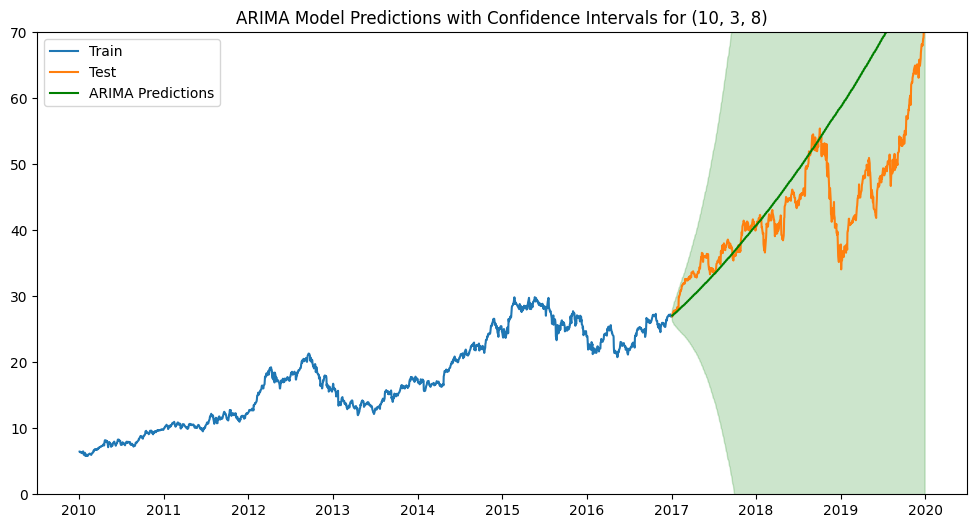

In [23]:
model = ARIMA(train_set, order=best_params).fit()

forecast = model.get_forecast(len(test_set))

pred = forecast.predicted_mean
conf_int = forecast.conf_int()

pred.index = test_set.index
conf_int.index = test_set.index

plt.figure(figsize=(12, 6))
plt.plot(train_set.index, train_set, label='Train')
plt.plot(test_set.index, test_set, label='Test')
plt.plot(pred.index, pred, label='ARIMA Predictions', color='green')

plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)
plt.ylim(0,70)
plt.legend()
plt.title(f'ARIMA Model Predictions with Confidence Intervals for {best_params}')

plt.show()


The error in the model's predictions has significantly reduced. While the confidence interval is still wide overall, it is much narrower for near-future values, indicating greater precision for those predictions.

#### 3.5 parameter $s$

In [24]:
def grid_search_arima_s(train_set, test_set, best_params):

    # s_list = [2, 4, 6, 10, 12, 20]
    s_list = [2, 4, 6]
    table_headers_s = ['s', 'MSE', 'MAE']
    arima_table_s = []

    best_mse = float('inf')
    best_param = None

    for s in s_list:
        
        model = ARIMA(train_set, seasonal_order=best_params + (s,)).fit()

        forecast = model.get_forecast(len(test_set))

        pred = forecast.predicted_mean
        conf_int = forecast.conf_int()

        pred.index = test_set.index
        conf_int.index = test_set.index

        mse = mean_squared_error(test_set, pred)
        mae = mean_absolute_error(test_set, pred)

        if mse < best_mse:
            best_mse = mse
            best_param = s

        arima_table_s.append([s, mse, mae])

    print(tb.tabulate(arima_table_s, headers=table_headers_s, tablefmt='pretty'))    
    return best_params + (best_param,), best_mse


In [25]:
best_params, best_score = grid_search_arima_s(train_set, test_set, best_params)
print(f"Best Parameters: {best_params}")
print(f"Best MSE Score: {best_score}")

+---+--------------------+--------------------+
| s |        MSE         |        MAE         |
+---+--------------------+--------------------+
| 2 | 44.96247989489992  | 6.037594057805621  |
| 4 | 197.5759357622643  | 12.301046033385926 |
| 6 | 189.84142621275384 | 12.047547129333106 |
+---+--------------------+--------------------+
Best Parameters: (10, 3, 8, 2)
Best MSE Score: 44.96247989489992


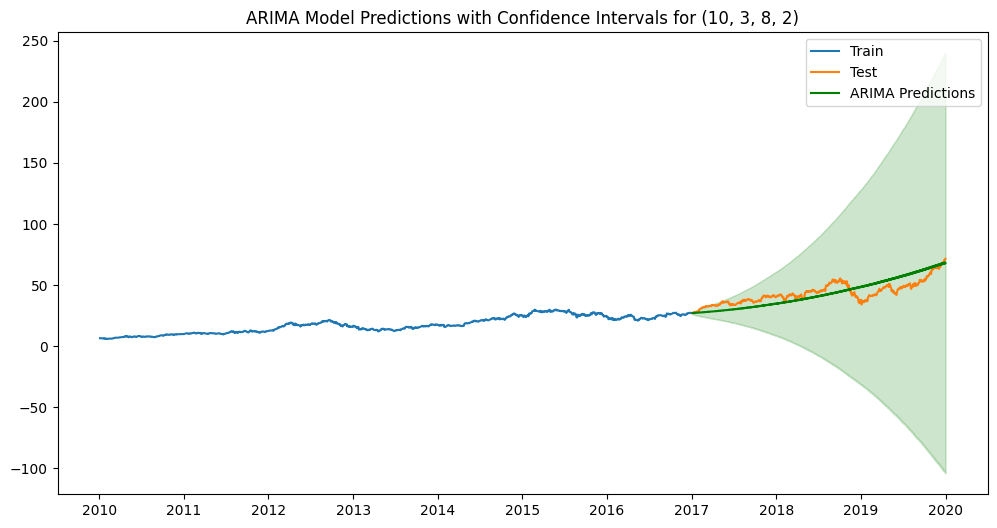

In [26]:
model = ARIMA(train_set, seasonal_order=best_params).fit()
forecast = model.get_forecast(len(test_set))

pred = forecast.predicted_mean
conf_int = forecast.conf_int()

pred.index = test_set.index
conf_int.index = test_set.index

plt.figure(figsize=(12, 6))
plt.plot(train_set.index, train_set, label='Train')
plt.plot(test_set.index, test_set, label='Test')
plt.plot(pred.index, pred, label='ARIMA Predictions', color='green')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)
plt.legend()
plt.title(f'ARIMA Model Predictions with Confidence Intervals for {best_params}')
plt.show()

### 4. Facebook Prophet

In [55]:
from prophet import Prophet
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
warnings.filterwarnings("ignore")

In [56]:
aapl_prophet_df = aapl_df.reset_index()[['Date', 'Adj Close']]
aapl_prophet_df.columns = ['ds', 'y']
aapl_prophet_df.head()

,ds,y
0,2010-01-04,6.470740
1,2010-01-05,6.481928
2,2010-01-06,6.378826
3,2010-01-07,6.367033
4,2010-01-08,6.409361


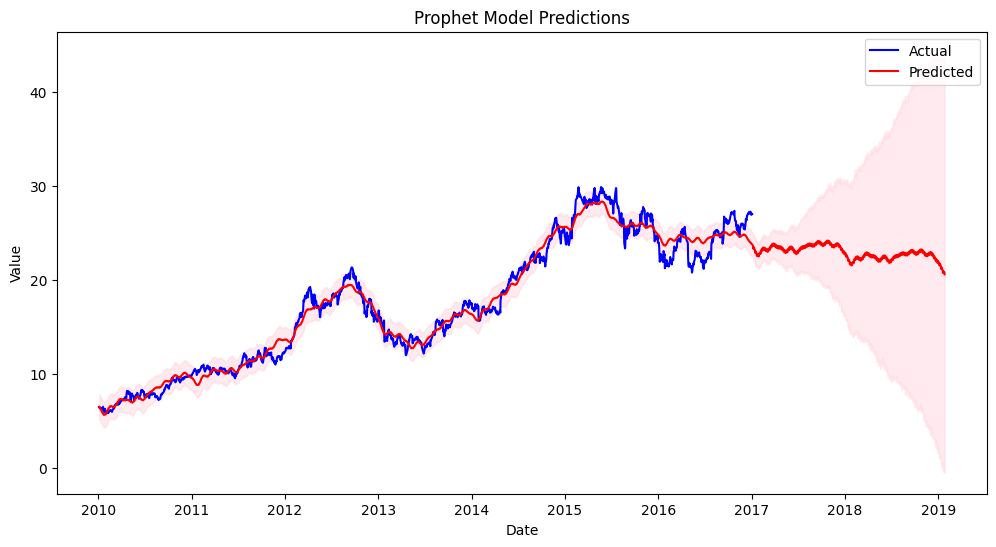

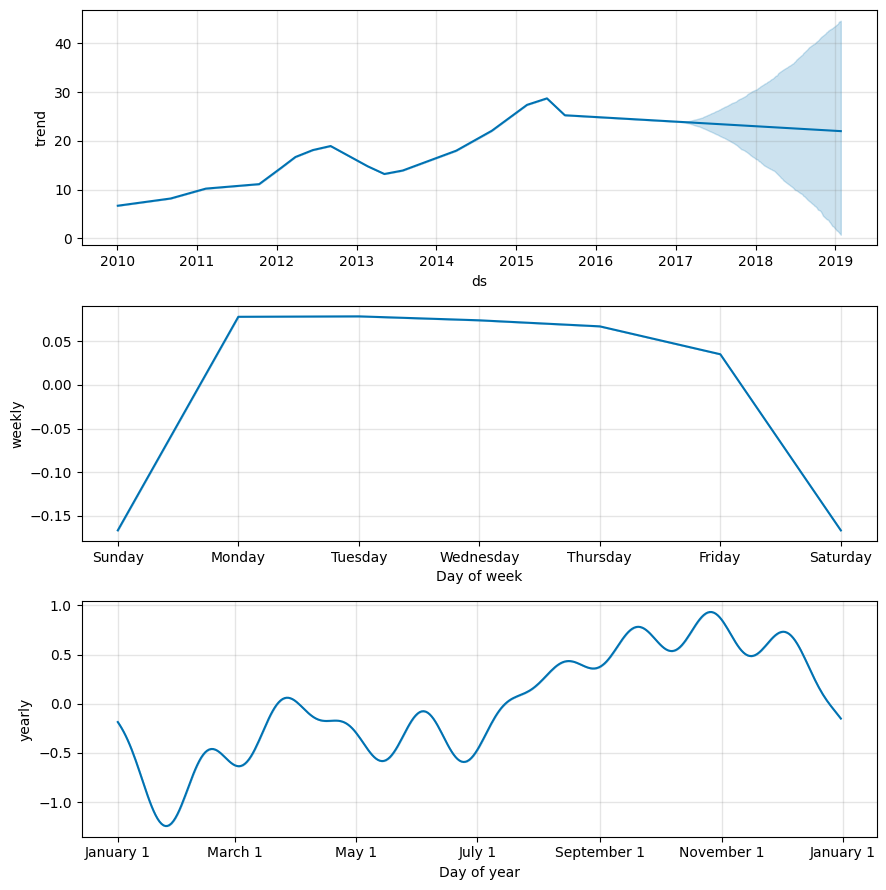

In [57]:
train_set, test_set = train_test_split(aapl_prophet_df, test_size=0.3, shuffle=False)

model = Prophet()
model.fit(train_set)

future = model.make_future_dataframe(periods=len(test_set))

forecast = model.predict(future)

plt.figure(figsize=(12, 6))

plt.plot(model.history['ds'], model.history['y'], label='Actual', color='blue')

plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='red')

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Prophet Model Predictions')
plt.legend()

plt.show()

model.plot_components(forecast)

plt.show()

We can see that weekly graph has low seasonalities (0.5), and yearly a lot more (6-8).

In [30]:
crashes = {
    '2010-04-27': 'European sovereign debt crisis',
    '2010-05-06': '2010 flash crash',
    '2011-08-01': 'August 2011 stock markets fall',
    '2015-06-12': '2015 Chinese stock market crash',
    '2015-08-18': '2015 stock market selloff',
    '2018-09-20': '2018 cryptocurrency crash',
    '2020-02-24': '2020 stock market crash',
    '2022-01-03': '2022 stock market decline',
    '2022-02-16': '2022 Russian stock market crash',
    '2024-02-02': '2024 China stock market crash'
}
# source: https://en.wikipedia.org/wiki/List_of_stock_market_crashes_and_bear_markets

holidays = {
    '2010-01-01': 'New Year 2010',
    '2010-12-25': 'Christmas 2010',
    '2010-7-4': 'Independence Day 2010',
    '2010-11-25': 'Thanksgiving 2010',
    '2011-12-25': 'Christmas 2011',
    '2011-7-4': 'Independence Day 2011',
    '2011-11-24': 'Thanksgiving 2011',
    '2012-12-25': 'Christmas 2012',
    '2012-7-4': 'Independence Day 2012',
    '2012-11-22': 'Thanksgiving 2012',
    '2013-12-25': 'Christmas 2013',
    '2013-7-4': 'Independence Day 2013',
    '2013-11-28': 'Thanksgiving 2013',
    '2014-12-25': 'Christmas 2014',
    '2014-7-4': 'Independence Day 2014',
    '2014-11-27': 'Thanksgiving 2014',
    '2015-12-25': 'Christmas 2015',
    '2015-7-4': 'Independence Day 2015',
    '2015-11-26': 'Thanksgiving 2015',
    '2016-12-25': 'Christmas 2016',
    '2016-7-4': 'Independence Day 2016',
    '2016-11-24': 'Thanksgiving 2016',
    '2017-12-25': 'Christmas 2017',
    '2017-7-4': 'Independence Day 2017',
    '2017-11-23': 'Thanksgiving 2017',
    '2018-12-25': 'Christmas 2018',
    '2018-7-4': 'Independence Day 2018',
    '2018-11-22': 'Thanksgiving 2018',
    '2019-12-25': 'Christmas 2019',
    '2019-7-4': 'Independence Day 2019',
    '2019-11-28': 'Thanksgiving 2019',
    '2020-12-25': 'Christmas 2020',
}

holidays_and_crashes_df = pd.DataFrame({
    'holiday': list(crashes.values()),
    'ds': pd.to_datetime(list(crashes.keys())),
    'lower_window': 0,
    'upper_window': 1,
})

holidays_df = pd.concat([holidays_and_crashes_df, pd.DataFrame({
    'holiday': list(holidays.values()),
    'ds': pd.to_datetime(list(holidays.keys())),
    'lower_window': 0,
    'upper_window': 1,
})])

In [58]:
def evaluate_model_prophet(train_set, test_set, yearly_seasonality, weekly_seasonality, holidays=None):
    model = Prophet(yearly_seasonality=yearly_seasonality, weekly_seasonality=weekly_seasonality, holidays=holidays)

    model.fit(train_set)

    future = model.make_future_dataframe(periods=len(test_set))
    forecast = model.predict(future)

    return mean_squared_error(test_set['y'], forecast['yhat'][-len(test_set):])


def grid_search_prophet(train_set, test_set, holidays_df=None):
    yearly_seasonality_list = [5,6,7]
    weekly_seasonality_list = [0.5, 1, 1.5]

    seasonality_prophet_table = []
    table_headers = ['Yearly Seasonality', 'Weekly Seasonality', 'MSE', 'MAE']

    best_params = None
    best_score = float('inf')

    for yearly_seasonality in yearly_seasonality_list:
        for weekly_seasonality in weekly_seasonality_list:

            
            mse = evaluate_model_prophet(train_set, test_set, yearly_seasonality,weekly_seasonality, holidays_df)
            seasonality_prophet_table.append([yearly_seasonality, weekly_seasonality, mse])
            
            # except Exception as e:
                # continue
            
            if mse < best_score:
                best_score = mse
                best_params = (yearly_seasonality, weekly_seasonality)

    print(tb.tabulate(seasonality_prophet_table, headers=table_headers, tablefmt='pretty'))
    return best_params, best_score

In [59]:
best_params, best_score = grid_search_prophet(train_set, test_set, holidays_df)
print(f"Best Parameters: {best_params}")
print(f"Best MSE Score: {best_score}")

+--------------------+--------------------+-------------------+
| Yearly Seasonality | Weekly Seasonality |        MSE        |
+--------------------+--------------------+-------------------+
|         5          |        0.5         | 504.6875760136945 |
|         5          |         1          | 504.4608948288098 |
|         5          |        1.5         | 504.4608948288098 |
|         6          |        0.5         | 503.1007016685103 |
|         6          |         1          | 500.6226997059932 |
|         6          |        1.5         | 500.6226997059932 |
|         7          |        0.5         | 512.249130891969  |
|         7          |         1          | 513.4752157624004 |
|         7          |        1.5         | 513.4752157624004 |
+--------------------+--------------------+-------------------+
Best Parameters: (6, 1)
Best MSE Score: 500.6226997059932


Result is a bit lower MSE, but not significantly.

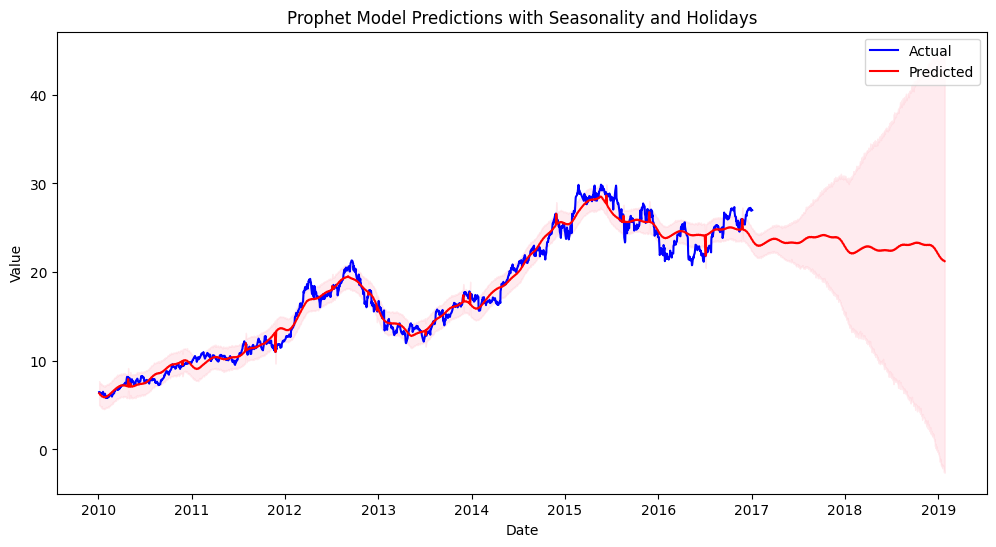

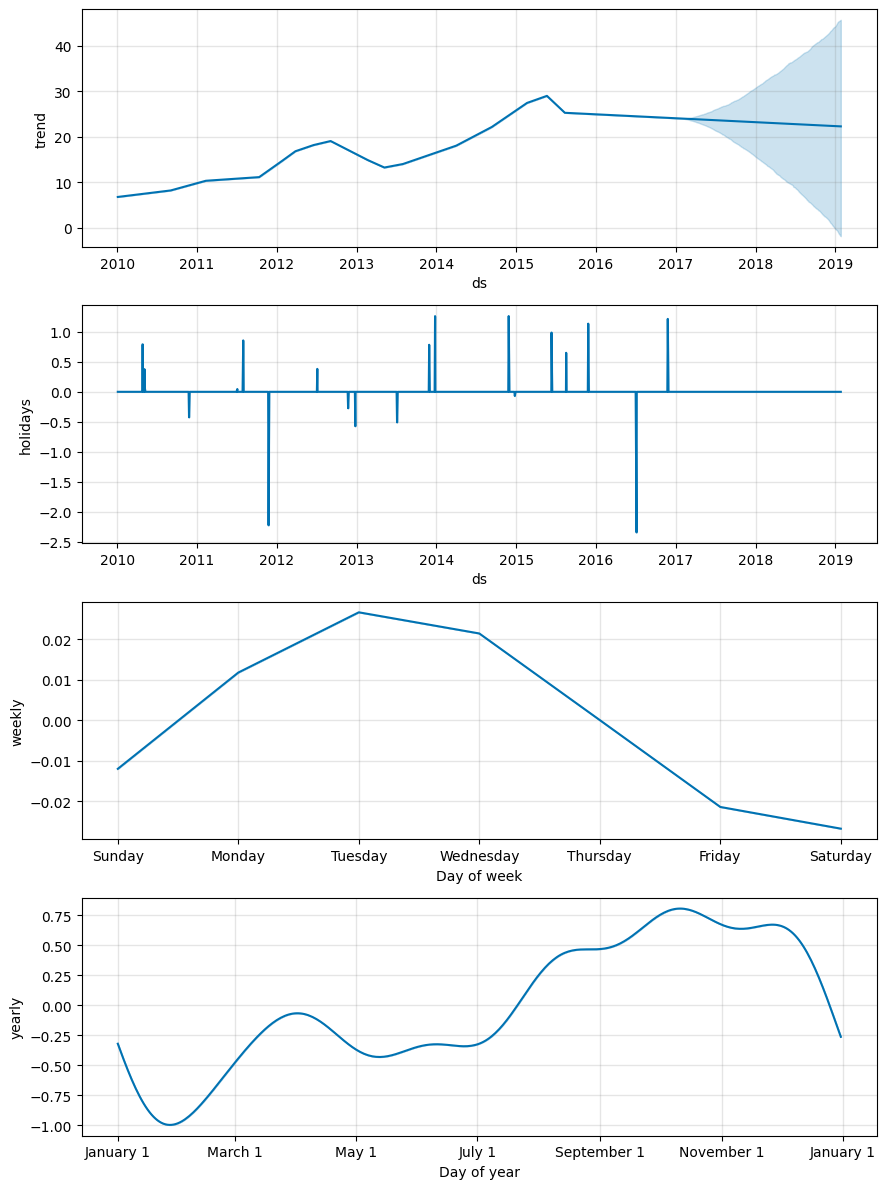

In [60]:
yearly_seasonality, weekly_seasonality = best_params

model = Prophet(yearly_seasonality=yearly_seasonality, weekly_seasonality=weekly_seasonality, holidays=holidays_df)
model.fit(train_set)

future = model.make_future_dataframe(periods=len(test_set))

forecast = model.predict(future)

plt.figure(figsize=(12, 6))

plt.plot(model.history['ds'], model.history['y'], label='Actual', color='blue')

plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='red')

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Prophet Model Predictions with Seasonality and Holidays')
plt.legend()

plt.show()

model.plot_components(forecast)

plt.show()

### 5. RandomForestRegressor

In [34]:
from sklearn.ensemble import RandomForestRegressor

Mean Squared Error: 266.5143740351438
Mean Absolute Error: 13.88955598486689


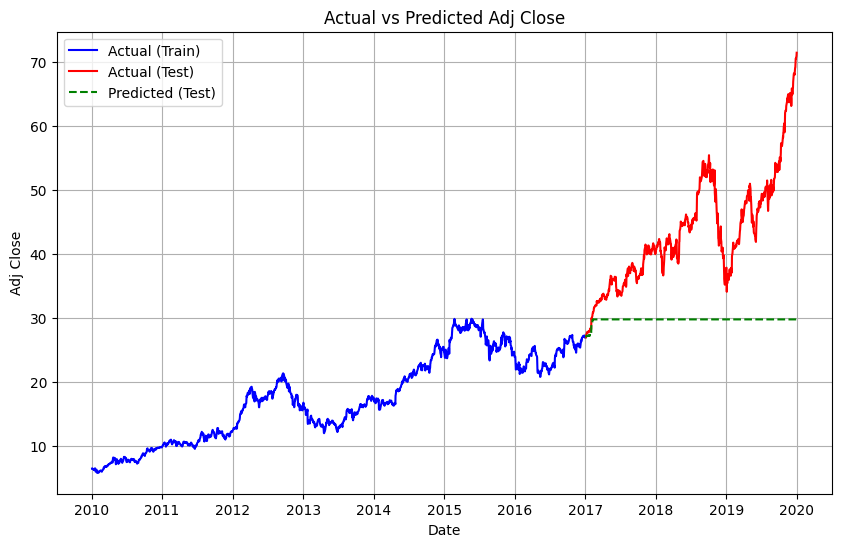

In [35]:
train_set, test_set = train_test_split(aapl_df, test_size=0.3, shuffle=False)

X_train = train_set.drop(columns=['Adj Close', 'Symbol'])
y_train = train_set['Adj Close']

X_test = test_set.drop(columns=['Adj Close', 'Symbol'])
y_test = test_set['Adj Close']

model = RandomForestRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)

mse = mean_squared_error(y_test, pred)
print(f'Mean Squared Error: {mse}')
mae = mean_absolute_error(y_test, pred)
print(f'Mean Absolute Error: {mae}')

plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train.values, label='Actual (Train)', color='blue')

plt.plot(y_test.index, y_test.values, label='Actual (Test)', color='red')
plt.plot(y_test.index, pred, label='Predicted (Test)', color='green', linestyle='--')

plt.title('Actual vs Predicted Adj Close')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.grid(True)
plt.show()

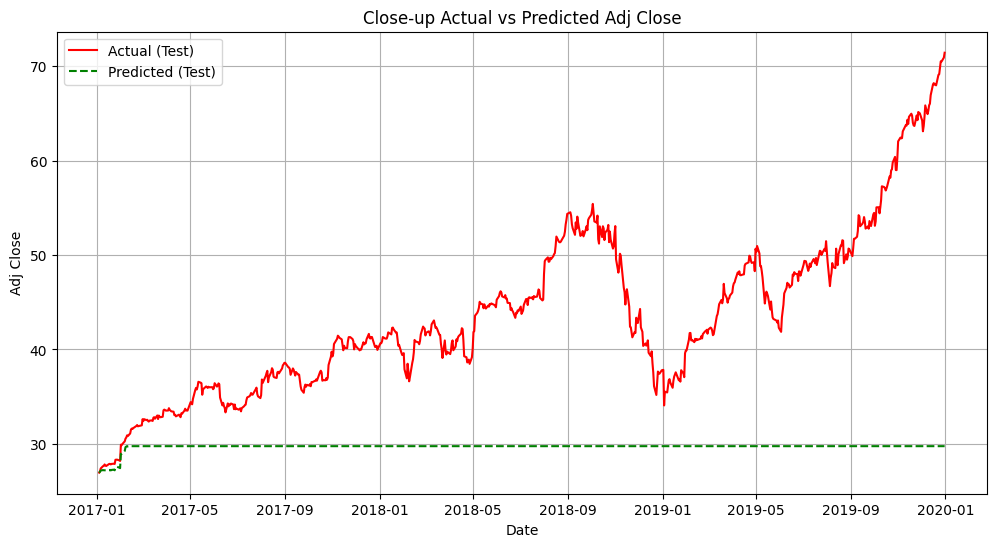

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual (Test)', color='red')
plt.plot(y_test.index, pred, label='Predicted (Test)', color='green', linestyle='--')

plt.title('Close-up Actual vs Predicted Adj Close')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.grid(True)
plt.show()

### 6. Generated signal

In [3]:
from scipy import signal
import numpy as np
warnings.filterwarnings("ignore")

In [4]:
t = np.linspace(0, 600, 600)
triangle1 = signal.sawtooth(2 * np.pi * 2 * 100 * t) 
triangle2 = signal.sawtooth(2 * np.pi * 2 * 28.57142857 * t, 0.63) 
trend = np.linspace(0, 600, 600)/(165*np.pi)
trend1 = np.linspace(0, 100, 100)/(112*np.pi)
trend2 = np.linspace(0, 300, 300)/(-103*np.pi)
trend3 = np.linspace(0, 200, 200)/(148*np.pi/2)
noise = np.random.normal(0,0.1056,600)
pts = triangle1 + triangle2 + trend + np.concatenate((trend1, trend2, trend3)) + noise

# constants
last_n_rows = 600
n_train_rows = 500

# split
pts_train = pts[:-(last_n_rows-n_train_rows)]
pts_test = pts[-(last_n_rows-n_train_rows):]

In [5]:
df = pd.DataFrame({
    't': np.arange(len(pts)),
    'pts': pts
})
df_train = df.iloc[:n_train_rows]
df_test = df.iloc[n_train_rows:]

df_train.head()

,t,pts
0,0,-2.112339
1,1,-0.498525
2,2,0.879499
3,3,-0.302771
4,4,-1.109036


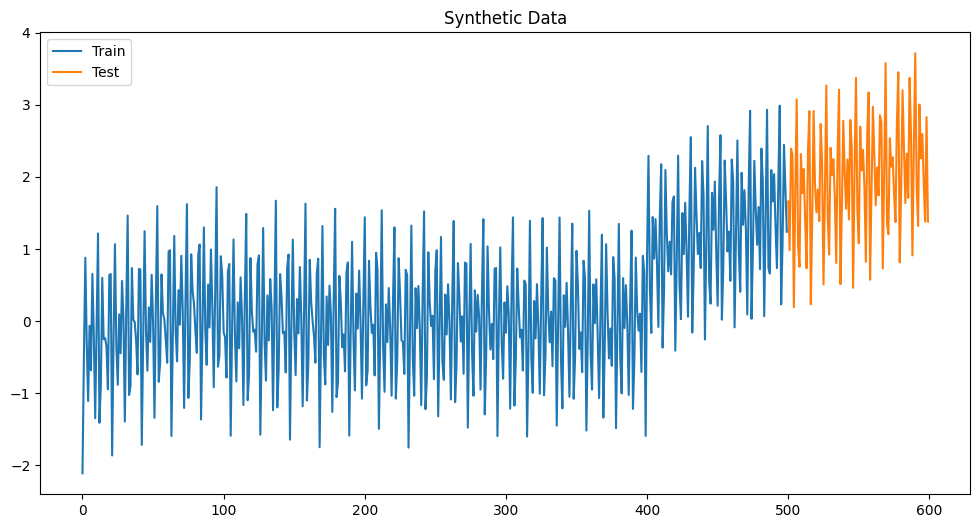

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df_train['t'], df_train['pts'], label='Train')
plt.plot(df_test['t'], df_test['pts'], label='Test')
plt.title('Synthetic Data')
plt.legend()
plt.show()

Components of the generated signal are triangles (waves), trends (with different slopes over different time intervals) and Gaussian white noise.

Yes, there is a periodicity

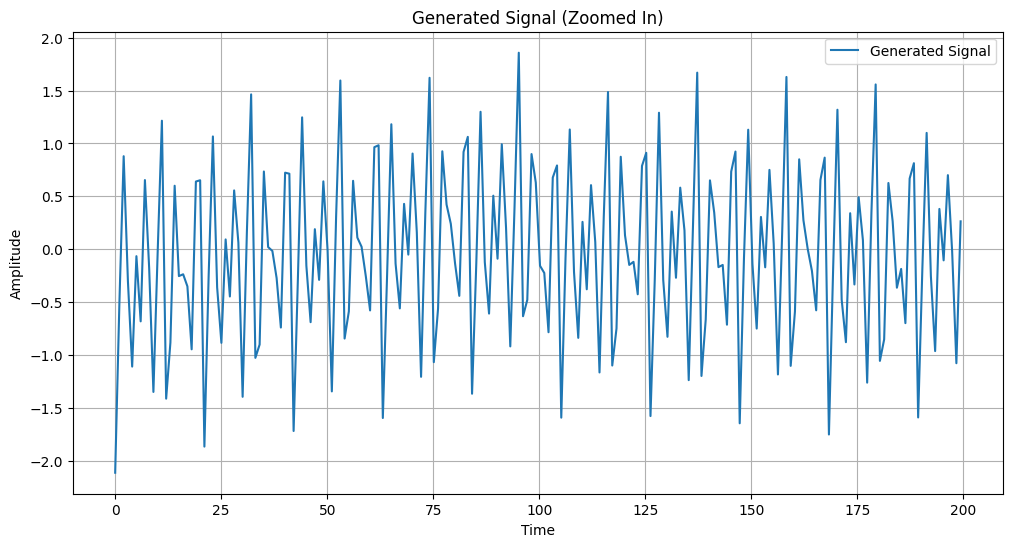

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(t[:200], pts[:200], label='Generated Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Generated Signal (Zoomed In)')
plt.legend()
plt.grid(True)
plt.show()


#### 6.1 Exponential smoothing

In [8]:

best_params, best_score = grid_search_exp(df_train['pts'], df_test['pts'], seasonal_periods_list=[3,10,30,60,61,62, 63, 126])
print(f"Best Parameters: {best_params}")
print(f"Best MAE Score: {best_score}")

NameError: name 'grid_search_exp' is not defined

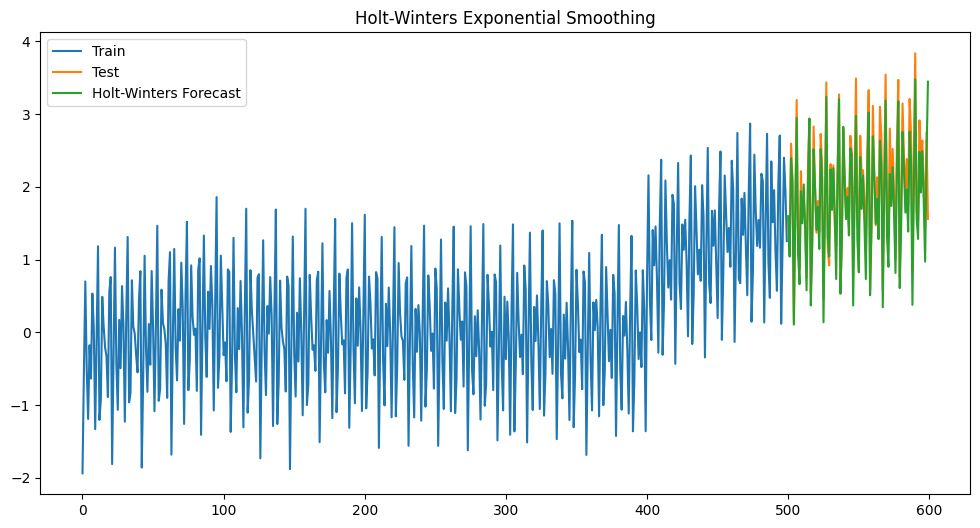

In [ ]:
best_trend, best_seasonal, best_seasonal_periods = best_params
model = ExponentialSmoothing(pts_train, trend=best_trend, seasonal=best_seasonal, seasonal_periods=best_seasonal_periods).fit()
pred = model.forecast(len(pts_test))

plt.figure(figsize=(12, 6))
plt.plot(df_train['t'], df_train['pts'], label='Train')
plt.plot(df_test['t'], df_test['pts'], label='Test')
plt.plot(df_test['t'], pred, label='Holt-Winters Forecast')
plt.legend()
plt.title('Holt-Winters Exponential Smoothing')
plt.show()

#### 6.2 ARIMA

In [ ]:
best_params, best_score = grid_search_arima(df_train['pts'], df_test['pts'], p_list=range(0,6), d_list=range(0,5), q_list=range(0,6))
print(f"Best Parameters: {best_params}")
print(f"Best MSE Score: {best_score}")

+---+---+---+---------------------+
| p | d | q |         MSE         |
+---+---+---+---------------------+
| 0 | 0 | 0 | 3.7488848817785474  |
| 0 | 0 | 1 | 3.7486192889464918  |
| 0 | 0 | 2 | 3.8376540460478386  |
| 0 | 0 | 3 |  3.711071556452883  |
| 0 | 0 | 4 |  3.655358210422623  |
| 0 | 0 | 5 | 3.6642278824185364  |
| 0 | 1 | 0 | 1.1849400869411888  |
| 0 | 1 | 1 | 0.9268365628729537  |
| 0 | 1 | 2 | 1.0480343103081182  |
| 0 | 1 | 3 | 0.7972739868640585  |
| 0 | 1 | 4 | 0.8367234711958873  |
| 0 | 1 | 5 | 0.8440425688666392  |
| 0 | 2 | 0 | 1738.4383478731556  |
| 0 | 2 | 1 | 0.7853312938152068  |
| 0 | 2 | 2 |  0.918023728315006  |
| 0 | 2 | 3 |  6.243542275694027  |
| 0 | 2 | 4 | 0.7761126860531938  |
| 0 | 2 | 5 | 0.6907286938085094  |
| 0 | 3 | 0 | 416482.57664045977  |
| 0 | 3 | 1 |  2610.78899855786   |
| 0 | 3 | 2 |  18.19846449006432  |
| 0 | 3 | 3 | 0.6294275742650134  |
| 0 | 3 | 4 | 189.34601665743085  |
| 0 | 3 | 5 |  94.24387696064188  |
| 0 | 4 | 0 |  8351438319.79

In [ ]:
best_params_s, best_score_s = grid_search_arima_s(df_train['pts'], df_test['pts'], best_params)
print(f"Best Parameters: {best_params_s}")
print(f"Best MSE Score: {best_score_s}")

+---+---------------------+---------------------+
| s |         MSE         |         MAE         |
+---+---------------------+---------------------+
| 2 | 0.11018761603080751 | 0.26318131722609456 |
| 4 | 3.4144947817724045  | 1.5303033440183953  |
| 6 | 0.1260395734215668  | 0.28234073980842717 |
+---+---------------------+---------------------+
Best Parameters: (5, 2, 4, 2)
Best MSE Score: 0.11018761603080751


Since seasonality does not help, we will not use it for this prediction.

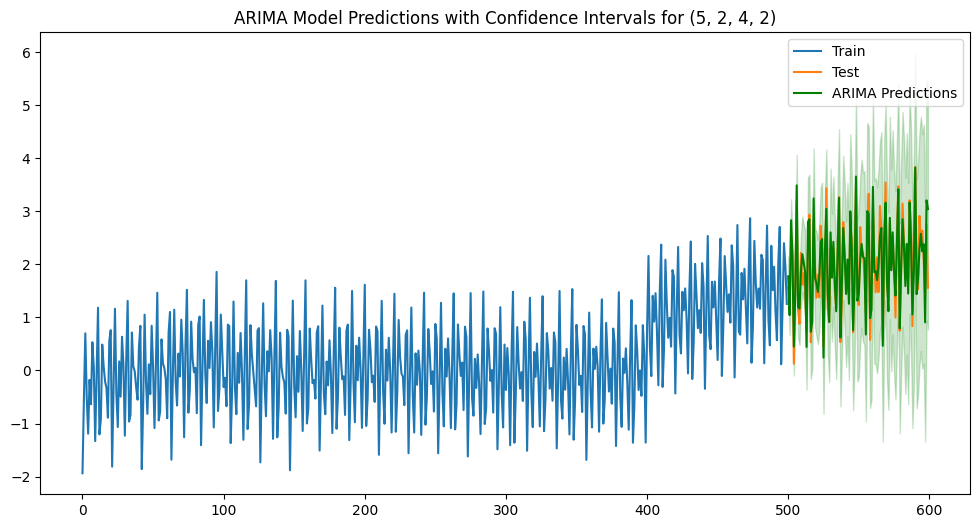

In [ ]:
model = ARIMA(df_train['pts'], order=best_params).fit()

forecast = model.get_forecast(len(df_test))

pred = forecast.predicted_mean
conf_int = forecast.conf_int()

pred.index = df_test.index
conf_int.index = df_test.index

plt.figure(figsize=(12, 6))
plt.plot(df_train.index, df_train['pts'], label='Train')
plt.plot(df_test.index, df_test['pts'], label='Test')
plt.plot(pred.index, pred, label='ARIMA Predictions', color='green')

plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)
plt.legend()
plt.title(f'ARIMA Model Predictions with Confidence Intervals for {best_params}')


plt.show()


#### 6.3 Prophet

In [ ]:
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
warnings.filterwarnings("ignore")

In [ ]:
prophet_df = pd.DataFrame({
    'ds': pd.date_range(start='2020-01-01', periods=len(pts), freq='D'),
    'y': pts
})
df_train = prophet_df.iloc[:n_train_rows]
df_test = prophet_df.iloc[n_train_rows:]

df_train.head()

,ds,y
0,2020-01-01,-1.936986
1,2020-01-02,-0.543896
2,2020-01-03,0.699601
3,2020-01-04,-0.508201
4,2020-01-05,-1.190187


In [ ]:
def grid_search_prophet_signal():
    period1_list = [1,2,3,4,5,6,10,20,30,40,80,200,300]
    period2_list = [1,2,3,4,5,6,10,20,30,40,80,200,300]

    table_headers_prophet = ['Period 1', 'Period 2', 'MSE']
    prophet_table = []

    best_mse = float('inf')
    best_params = None
    for period1 in period1_list:
        for period2 in period2_list:
            model = Prophet()
            model.add_seasonality(name='triangle1_seasonality', period=period1, fourier_order=5)
            model.add_seasonality(name='triangle2_seasonality', period=period2, fourier_order=5)

            model.fit(df_train)

            future = model.make_future_dataframe(periods=len(df_test))

            forecast = model.predict(future)

            mse = mean_squared_error(df_test['y'], forecast['yhat'][-len(df_test):])
            prophet_table.append([period1, period2, mse])

            if mse < best_mse:
                best_mse = mse
                best_params = (period1, period2)

    print(tb.tabulate(prophet_table, headers=table_headers_prophet, tablefmt='pretty'))
    return best_params, best_mse

In [ ]:
best_params, best_mse = grid_search_prophet_signal()
print(f"Best Parameters: {best_params}")
print(f"Best MSE Score: {best_mse}")

+----------+----------+---------------------+
| Period 1 | Period 2 |         MSE         |
+----------+----------+---------------------+
|    1     |    1     | 0.7559665992910939  |
|    1     |    2     | 0.7398033505199956  |
|    1     |    3     | 0.36907543186494807 |
|    1     |    4     | 0.8022101765435472  |
|    1     |    5     | 0.7986072569690722  |
|    1     |    6     | 0.36788610591787946 |
|    1     |    10    | 0.7655768786230344  |
|    1     |    20    | 0.7787395832197734  |
|    1     |    30    | 0.7678616752838237  |
|    1     |    40    | 0.8031875234179566  |
|    1     |    80    | 0.7751592117572018  |
|    1     |   200    |  1.340157079110976  |
|    1     |   300    | 1.9244436544193086  |
|    2     |    1     | 0.7398293683920454  |
|    2     |    2     | 0.7752986057681467  |
|    2     |    3     |  0.369126396812079  |
|    2     |    4     |  0.794143001693012  |
|    2     |    5     | 0.7319946993090777  |
|    2     |    6     | 0.36724942

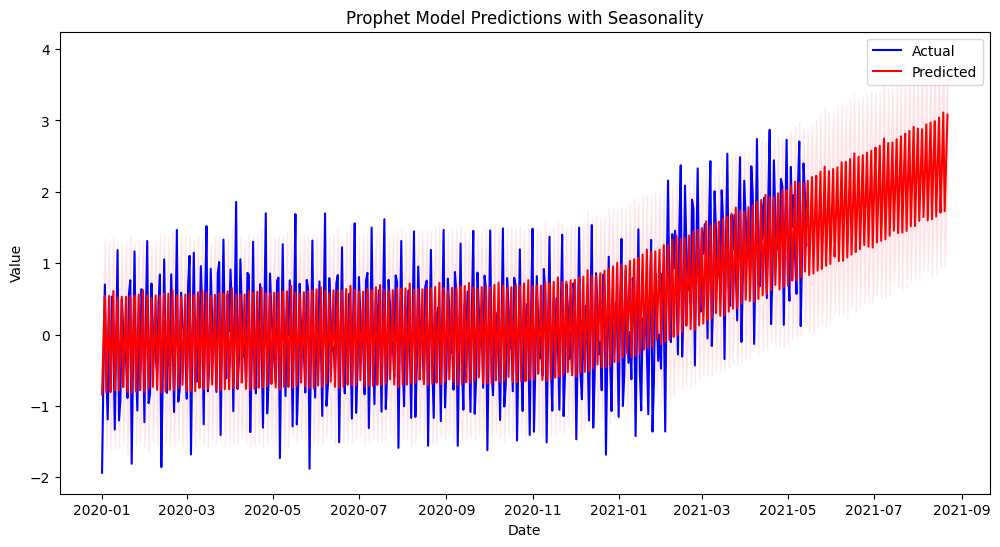

In [ ]:
parameter1, parameter2 = best_params

model = Prophet()
model.add_seasonality(name='triangle1_seasonality', period=6, fourier_order=5)
model.add_seasonality(name='triangle2_seasonality', period=5, fourier_order=5)

model.fit(df_train)
future = model.make_future_dataframe(periods=len(df_test))
forecast = model.predict(future)

plt.figure(figsize=(12, 6))
plt.plot(model.history['ds'], model.history['y'], label='Actual', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Prophet Model Predictions with Seasonality')
plt.legend()
plt.show()